# Overview

1. Build a model that can tell airbnb hosts how much they should be able to rent their listings for.
2. Determine what features most impact the pricing so that the hosts could rent their listings for more.

# Data Understanding
I am going to to take a look at the New York AirBnB data: http://insideairbnb.com/get-the-data.html.

In [58]:
import numpy as np
import pandas as pd
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', style='darkgrid', palette='deep', font_scale=1.5, color_codes=True)


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

In [59]:
conn = sqlite3.connect('data/airbnb.db')
listings_df = pd.read_sql('SELECT * FROM listings', con = conn)

# Drop variables will all there values missing
listings_df.dropna(axis=1, how='all', inplace=True)

# Drop variables that are the same for every listing
for col in listings_df:
    if listings_df[col].value_counts().shape[0] == 1:
        listings_df.drop(columns=col, inplace=True)
        
# List all the variables
print(listings_df.shape)

(50378, 101)


There are many variables (columns in the pandas DataFrame) that have data from every single listing (rows in the pandas DataFrame).

In [60]:
no_nulls = listings_df.columns[listings_df.isnull().mean() == 0]
print('There are %d columns with no missing values.' % (no_nulls.shape[0]))

There are 52 columns with no missing values.


In [61]:
most_missing_cols = listings_df.columns[listings_df.isnull().mean() > 0.5]

print('There are %d columns with more than half of their values missing.' % (most_missing_cols.shape[0]))
set(most_missing_cols)

There are 6 columns with more than half of their values missing.


{'jurisdiction_names',
 'license',
 'monthly_price',
 'notes',
 'square_feet',
 'weekly_price'}

Average prices

In [62]:
print('The average cost of a rental is $%d.' % (listings_df['price'].mean()))
print('The average cleaning fee is $%d.' % (listings_df['cleaning_fee'].mean()))
print('The average security deposit is $%d.' % (listings_df['security_deposit'].mean()))

The average cost of a rental is $164.
The average cleaning fee is $70.
The average security deposit is $271.


There are some very expensive listings that are not representive of a typical airbnb listing.

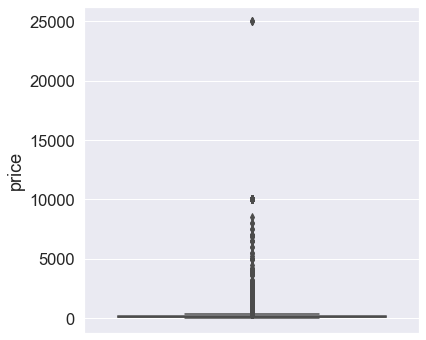

In [63]:
plt.figure(figsize = (6, 6))
sns.boxplot(y = 'price',  data = listings_df)
xt = plt.xticks(rotation=90)

Use the Tukey rule to determine which high price listings are outliers. Therefore, this model will not be useful when pricing high-end listings.

In [64]:
Q1 = listings_df['price'].quantile(0.25)
Q3 = listings_df['price'].quantile(0.75)

IQR = Q3 - Q1
max_value = Q3 + 1.5 * IQR


print("Any listing more than $%d will be discarded" % max_value)
listings_df = listings_df[(listings_df['price'] < max_value)].reset_index(drop=True)

Any listing more than $335 will be discarded


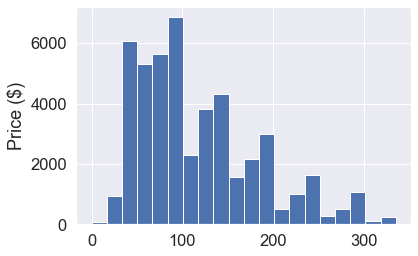

In [65]:
listings_df['price'].hist(bins=20)
plt.ylabel("Count");
plt.ylabel("Price ($)");

Now lets do a first past to examine how much the features seem to matter in predicting price.

In [66]:
def plot_price_dist(df, col):

    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    sns.boxplot(x = col, y ='price',  data = df, ax=ax1)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    
    
    listings_df[col].value_counts().sort_index().plot(kind='bar', ax=ax2);
    plt.ylabel("Count");
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

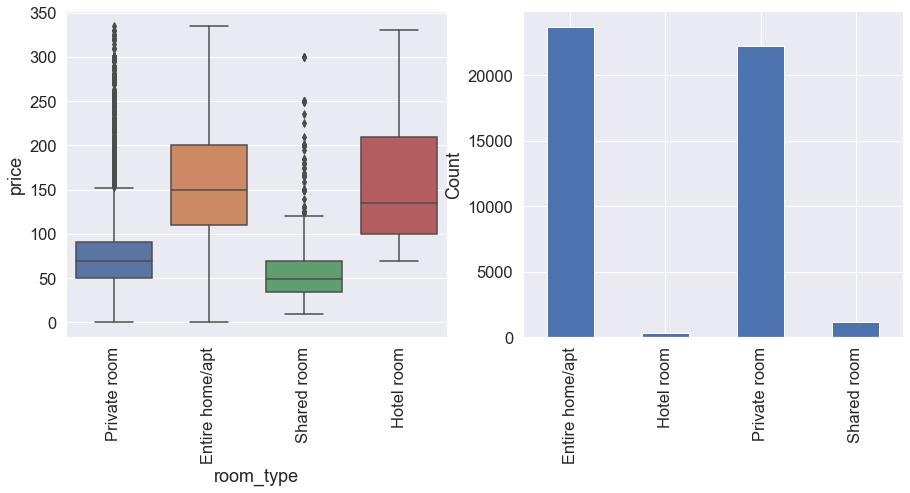

In [67]:
# Room type very much effects 
plot_price_dist(listings_df, 'room_type')

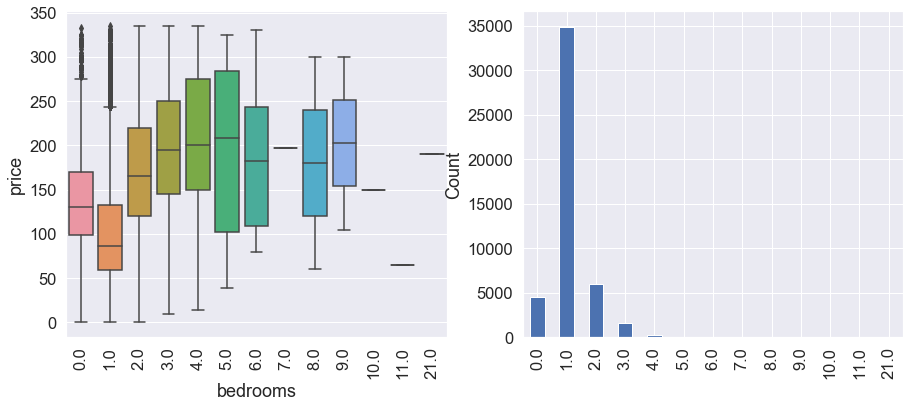

In [68]:
plot_price_dist(listings_df, 'bedrooms')

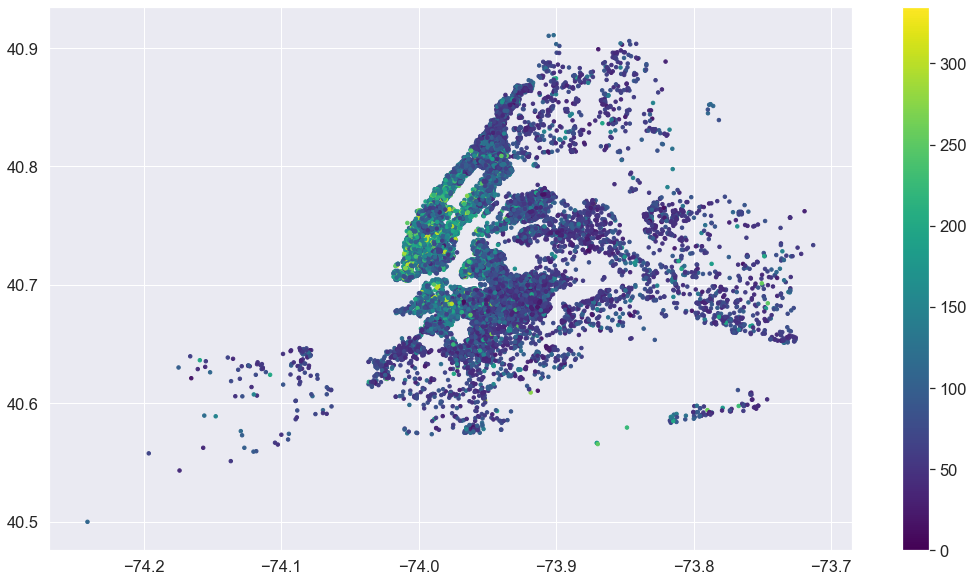

In [69]:
plt.figure(figsize=[18,10])
plt.scatter(listings_df[listings_df['accommodates']==2]['longitude'],
            listings_df[listings_df['accommodates']==2]['latitude'],
            c=listings_df[listings_df['accommodates']==2]['price'], cmap='viridis',s=12)
cbar = plt.colorbar()

# Building a Model

### Can we predict a price just by looking at your neighbors?

For a first try lets use a k-nearest neighbors model. The model is overfitting.

In [70]:
knn_features = listings_df[['longitude', 'latitude','accommodates']]
price = listings_df['price']

# Split data into training and test data, and fit a linear model
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(knn_features, price, 
                                                                    test_size=.2, random_state=17)

In [71]:
neigh = KNeighborsRegressor(n_neighbors=5).fit(X_knn_train, y_knn_train)

In [72]:
def print_errors(model, X_train, y_train, X_test, y_test ):
    print("The mean squared error on the train set is $%f" % mean_squared_error(model.predict(X_train), y_train)**0.5)
    print("The mean squared error on the train set is $%f" % mean_squared_error(model.predict(X_test), y_test)**0.5)

In [73]:
print_errors(neigh, X_knn_train, y_knn_train, X_knn_test, y_knn_test)

The mean squared error on the train set is $40.627590
The mean squared error on the train set is $50.267302


In [74]:
neigh_50 = KNeighborsRegressor(n_neighbors=50).fit(X_knn_train, y_knn_train)

In [75]:
print_errors(neigh_50, X_knn_train, y_knn_train, X_knn_test, y_knn_test)

The mean squared error on the train set is $46.272367
The mean squared error on the train set is $48.004564


### A linear model with many features
Now build a linear model with more features to see if we can do better.

In [82]:
features = listings_df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included',
                       'number_of_reviews', 'review_scores_rating', 'Doorman', 'Gym', 'Pool', 'Fireplace',
                        'Washer/Dryer', 'TV', 'Breakfast', 'Dog(s)', 'Cat(s)', 'Hot tub']]

In [83]:
# Add the true/false features and change them from 'f' and 't' to 0 or 1.
tf_cols = ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','instant_bookable',
           'require_guest_profile_picture', 'require_guest_phone_verification']

for col in tf_cols:
    new_feature = listings_df[col].map(lambda s: 0 if s == "f" else 1)
    features.insert(column=col, value=new_feature, loc=0) 

Next I will convert categorical features to dummy features

In [84]:
cat_col = ['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type']
for col in cat_col:
    features = pd.concat([features, pd.get_dummies(listings_df[col], prefix=col[0:5], prefix_sep='_', 
                                                   drop_first=True, dummy_na=True)], axis=1)

There are several features that have missing values.

In [85]:
features.columns[features.isnull().mean() > 0]

Index(['bathrooms', 'bedrooms', 'beds', 'review_scores_rating'], dtype='object')

So as to not waste this data I will impute the mean.

In [86]:
fill_mean = lambda col: col.fillna(col.mean()) 
features = features.apply(fill_mean, axis=0) 

This linear model is using 291 features

In [88]:
features.shape

(47366, 291)

In [89]:
# Split data into training and test data, and fit a linear model
X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=.2, random_state=42)

Use a grid search to find an optimal value of the Regularization parameter 'alpha' to prevent overfitting the 296 features.

In [90]:
rid = Ridge()
param_grid = [{'alpha': np.arange(20)*0.2}]
gs = GridSearchCV(estimator=rid, param_grid=param_grid, cv=10)
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid=[{'alpha': array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [91]:
gs.best_params_

{'alpha': 3.2}

In [92]:
rid = gs.best_estimator_.fit(X_train, y_train)

In [93]:
print_errors(rid, X_train, y_train, X_test, y_test)

The mean squared error on the train set is $43.016770
The mean squared error on the train set is $43.121212


In [94]:
def print_imp_features(model, threshold):
    print("Start with $%d" % model.intercept_)
    for i, c in enumerate(model.coef_):
        if c > threshold or c < -threshold:
            print("$%f for %s" % (c, X_train.columns[i]))

In [95]:
# Which features change the price by more than $5
print_imp_features(rid, 5)

Start with $63
$7.962225 for require_guest_phone_verification
$-5.642838 for require_guest_profile_picture
$8.418778 for accommodates
$5.658892 for bathrooms
$13.119399 for bedrooms
$12.328887 for Doorman
$15.264958 for Gym
$9.232751 for Pool
$-11.160969 for Fireplace
$16.139567 for Washer/Dryer
$7.925925 for TV
$-17.545678 for neigh_Arden Heights
$-22.220107 for neigh_Arrochar
$-5.021243 for neigh_Arverne
$-8.323087 for neigh_Bath Beach
$40.654292 for neigh_Battery Park City
$-7.181035 for neigh_Bay Ridge
$-12.288369 for neigh_Bay Terrace, Staten Island
$-5.572417 for neigh_Baychester
$-8.204971 for neigh_Bayside
$46.560367 for neigh_Belle Harbor
$-12.885787 for neigh_Belmont
$-19.352323 for neigh_Bensonhurst
$-27.327373 for neigh_Bergen Beach
$34.826560 for neigh_Boerum Hill
$-9.145386 for neigh_Borough Park
$39.806848 for neigh_Breezy Point
$-22.168939 for neigh_Bronxdale
$41.749445 for neigh_Brooklyn Heights
$-7.147008 for neigh_Brownsville
$-26.064536 for neigh_Bull's Head
$-5.931

In [96]:
# Here are the very most important features
print_imp_features(rid, 50)

Start with $63
$59.585064 for neigh_Chelsea
$50.252868 for neigh_DUMBO
$66.209442 for neigh_Flatiron District
$68.576995 for neigh_Greenwich Village
$53.115078 for neigh_Hell's Kitchen
$60.520995 for neigh_Midtown
$71.181993 for neigh_NoHo
$59.152637 for neigh_Nolita
$63.173739 for neigh_SoHo
$78.178642 for neigh_Tribeca
$74.441869 for neigh_West Village
$-70.891178 for prope_Camper/RV
$-70.095894 for room__Shared room


### A nonlinear model
Can a nonlinear regressor do better? Yes, the data has some nonlinearities, (e.g. diminishing price returns for number of bedrooms). 

In [97]:
mlp = MLPRegressor(activation='relu',max_iter=2000, hidden_layer_sizes=(50,8)).fit(X_train, y_train)

In [98]:
print_errors(mlp, X_train, y_train, X_test, y_test)

The mean squared error on the train set is $39.375779
The mean squared error on the train set is $41.804584


In [99]:
np.mean(np.abs(mlp.predict(X_test)- y_test))

29.786069748726824

# Summary

1. The best model can predict past listings to within an average of $30. 
2. The most impactful features are neighborhood, property type, room type, bedrooms, and number of guests accomdated.
3. The most ammmenities most likely to change the value of your listing are having a TV, Washer, Fireplace, Doorman, Gym, or a Pool.